## Importing libraries

In [4]:
import cobra
from cobra.core import Metabolite, Reaction, Model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import importlib
# import d3flux

In [5]:
from cobra.flux_analysis import flux_variability_analysis
import plotly.io as pio
import plotly.express as px
# import escher
# from escher import Builder

In [6]:
import Utils_Cobrapy
importlib.reload(Utils_Cobrapy)

<module 'Utils_Cobrapy' from 'c:\\Users\\home\\Desktop\\Fac\\Master bio-info\\M2\\Stage\\2023\\Utils_Cobrapy.py'>

In [7]:
# import viz_utils
# importlib.reload(viz_utils)

In [8]:
dir (Utils_Cobrapy)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'define_boundary_and_run_model',
 'flux_variability_analysis',
 'get_fluxes_from_mitocore_metabolite',
 'get_mitocore_respiratory_exchange_ratio',
 'get_sum_fluxes',
 'heatmap_flux',
 'np',
 'pd',
 'plot_voie_metabolique_ou_accoa',
 'plt',
 'run_model_calpainopathy',
 'sns']

## Loading sbml model

In [9]:
# Loading one model for each condition

mitocore_mouse25=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse65=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse85=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse100=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse100_calpain=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse25_calpain=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse65_calpain=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse85_calpain=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")

### Choosing the solver

In [10]:
models_to_use = [mitocore_mouse25, mitocore_mouse65, mitocore_mouse85, mitocore_mouse100, mitocore_mouse100_calpain, mitocore_mouse25_calpain, mitocore_mouse65_calpain, mitocore_mouse85_calpain]

for model in models_to_use:
    model.solver = 'glpk'

In [11]:
mitocore_mouse25

Name,S1SBMLmodel
Memory address,0x01c542fb7a00
Number of metabolites,441
Number of reactions,554
Number of groups,96
Objective expression,1.0*OF_ATP_MitoCore - 1.0*OF_ATP_MitoCore_reverse_653d9
Compartments,"Cytosol, Mitochondrion, External"


## Variables

In [12]:
dict_results_voie_metabolique=dict()
dict_results_accoa=dict()
dict_results_atp=dict()

In [13]:
# print(mitocore_mouse.reactions.OF_ATP_MitoCore.bounds)

## Functions for data visualisation

In [14]:
def build_dataframe(model, soluce, threshold_down, threshold_up, hide_transport=True):
    df_percent = soluce.to_frame()
    subsystems = []

    for index, row in df_percent.iterrows():
        notes = model.reactions.get_by_id(index).notes
        if notes != {}:
            subsystems.append(notes['SUBSYSTEM'])
        else:
            subsystems.append('unknown')

    df_percent['Subsystems'] = subsystems
    df_percent['Reactions'] = df_percent.index
    df_percent_sort = df_percent.loc[df_percent['fluxes'] > threshold_down]
    df_percent_sort = df_percent_sort.loc[df_percent_sort['fluxes'] < threshold_up]
    df_percent_sort = df_percent_sort.loc[df_percent_sort['Subsystems'] != 'unknown']

    if hide_transport:
        row2drop = []
        subsystems_to_hide = ['Electron transport chain', 'TCA cycle', 'Boundary conditions - core', 'Mitochondrial transport - diffusion / artificial', 'Mitochondrial transporters - characterised', 'Objective Function - ATP']
        # subsystems_to_hide = ['Electron transport chain', 'Boundary conditions - core', 'Mitochondrial transport - diffusion / artificial']
        
        for index, row in df_percent_sort.iterrows():
            if any(x in row['Subsystems'] for x in subsystems_to_hide):
                row2drop.append(index)

        df_percent_sort = df_percent_sort.drop(row2drop)

    return df_percent_sort

In [15]:
list_a = [1, "a", 9, "c", "d"]
list_b = [3, 1]
any(x in list_a for x in list_b)

True

In [16]:
def build_dataframe_visual(model, soluce, fva = False):

    if fva:
        df_percent = soluce
    else:
        df_percent = soluce.to_frame()

    subsystems = []

    for index, row in df_percent.iterrows():
        notes = model.reactions.get_by_id(index).notes
        if notes != {}:
            subsystems.append(notes['SUBSYSTEM'])
        else:
            subsystems.append('unknown')

    df_percent['Subsystems'] = subsystems
    df_percent['Reactions'] = df_percent.index

    if fva:
        df_percent = df_percent.sort_values(by=['Subsystems'])
    else:
        df_percent = df_percent.sort_values(by=['Subsystems', 'fluxes'])

    print(df_percent.to_markdown())
    return df_percent

In [17]:
def display_treemap(dataframe, name):
  fig = px.treemap(dataframe,
    path = [px.Constant('Cell'),'Subsystems', 'Reactions'],
    values = 'fluxes',
    color = 'fluxes',
    color_continuous_scale=px.colors.diverging.RdBu[::-1],
    # color_continuous_scale=px.colors.diverging.curl,
    # color_continuous_scale=px.colors.cyclical.HSV,
    width = 1400,
    height = 900
  )
  fig.update_traces(textinfo = "label+value",textposition="middle center",hovertemplate='Pathway or enzyme=%{label}<br>Flux=%{value}<br>Percentage=.%{percent entry}<extra></extra>')
  # fig.update_traces(hovertext=['fluxes'])

  
  # Changement du layout
  fig.update_layout(
    {'font_color': "white",
    'plot_bgcolor': 'rgba(0, 0, 0, 100)',
    'paper_bgcolor': '#2e2d2d'},
    title = f"Treemaps of metabolic pathways for {name}% physical intensity",
    title_x=0.5,
    title_y=0.97
    )

  fig.show()

In [18]:
def print_reactions_from_met(model, metabolite, solution, notNull = True):
    reactions = model.metabolites.get_by_id(metabolite).reactions
    for r in reactions:
        flux = solution.to_frame().loc[r.id]
        if notNull:
            if flux['fluxes'] != 0:
                print(r)
                print(solution.to_frame().loc[r.id])
                print('--------')
        else:
            print(r)
            print(solution.to_frame().loc[r.id])
            print('--------')

In [19]:
def get_reactions_from_subsys(model, dt_fluxes, list_of_subsys):
    for subsys in list_of_subsys:
        print(f"\n------ Reactions from {subsys} -------\n")
        df_subsys = dt_fluxes.loc[dt_fluxes['Subsystems'] == subsys]
        for index, row in df_subsys.iterrows():
            print(model.reactions.get_by_id(index))
            print(f"{row['fluxes']}\n")

In [20]:
def get_alternative_pathways(fva_dt):
    essential_react = []
    alternative = []

    for index, row in fva_dt.iterrows():
        if row['minimum'] != row['maximum']:
            alternative.append(index)
        else: # if row['minimum'] > 0:
            essential_react.append(index)

    return alternative

In [21]:
def get_reactions_to_check(all_fluxes_dt, alternative, subsys):
    reaction_to_check = []

    for react_id in alternative:
        reaction = all_fluxes_dt.loc[react_id]
        if reaction['fluxes'] == 0 and reaction['Subsystems'] == subsys:
            # print(reaction['Subsystems'])
            reaction_to_check.append(react_id)

    return reaction_to_check

In [22]:
def print_alternative_reactions(list_id, fva_dt):
    for react_id in list_id:
        print(fva_dt.loc[react_id])
        print("---------------------------")

In [23]:
# dict_tot = {'25':0,'65':0,'85':0, '100':0} 
# dict_prop={'25':{},'65':{},'85':{}, '100':{}}
def build_dict_proportion(dict_pathway, dict_tot={'25':0,'65':0,'85':0}, dict_prop={'25':{},'65':{},'85':{}}):
    for intensity in dict_pathway:
        for pathway in dict_pathway[intensity]:
            dict_tot[intensity] += dict_pathway[intensity][pathway]
    
    for intensity in dict_pathway:
        for pathway in dict_pathway[intensity]:
            dict_prop[intensity][pathway] = dict_pathway[intensity][pathway] / dict_tot[intensity]
    
    return dict_prop

## Test sur les changements de fonctions objectif
### Glucose et lipide en FO

In [24]:
# reaction_FO = Reaction("GLULIP")
# reaction_FO.bounds = (0, 1000)
# mitocore_mouse25.reactions.HDCAtr

In [25]:
# mitocore_mouse25.objective = {mitocore_mouse25.reactions.GLCt1r: 1, mitocore_mouse25.reactions.HDCAtr: 1}
# print(mitocore_mouse25.objective)

In [26]:
# mitocore_mouse25.reactions.OF_ATP_MitoCore.bounds = (14.6, 14.6)
# mitocore_mouse25.reactions.O2t.bounds = (3.7, 3.7)
# mitocore_mouse25.reactions.GLCt1r.upper_bound = 0.36
# mitocore_mouse25.reactions.HDCAtr.upper_bound = 0.6

In [27]:
# sum_two = mitocore_mouse25.problem.Constraint(
#     0.4*mitocore_mouse25.reactions.GLCt1r.flux_expression + 0.6*mitocore_mouse25.reactions.HDCAtr.flux_expression, 
#     lb=2,
#     up=2
# )

In [28]:
# new_obj = mitocore_mouse25.problem.Objective(
#     0.4 * mitocore_mouse25.reactions.GLCt1r.flux_expression + 0.6 * mitocore_mouse25.reactions.HDCAtr.flux_expression
# )
# mitocore_mouse25.objective = new_obj
# print(mitocore_mouse25.objective)

In [29]:
# sol25 = mitocore_mouse25.optimize()
# all_25 = build_dataframe_visual(mitocore_mouse25, sol25)

In [30]:
# dict_voie_metabolique=dict()
# dict_voie_metabolique["glycolyse"]=abs(mitocore_mouse25.reactions.PGM.flux)
# dict_voie_metabolique["beta oxydation"]=abs(mitocore_mouse25.reactions.r0732.flux)
# dict_voie_metabolique["ketone bodies"]=abs(mitocore_mouse25.reactions.BDHm.flux)
# dict_voie_metabolique["leucine degradation"]=abs(mitocore_mouse25.reactions.LEUTAm.flux)
# dict_voie_metabolique["isoleucine degradation"]=abs(mitocore_mouse25.reactions.ILETAm.flux)
# dict_voie_metabolique

## Options

In [31]:
VO2max_25 = True
VO2max_65 = True
VO2max_85 = True
VO2max_100 = True

mouse_WT = True
mouse_calpain = True

## Mice model WT

In [32]:
# mitocore_mouse.reactions.EX_hdca_e.bounds = (-1000, 0)
# mitocore_mouse.reactions.FACOAL160i.bounds = (2.58, 1000)
# mitocore_mouse.reactions.r0732.bounds = (0.76,1000)

In [33]:
mitocore_mouse25.reactions.HDCAtr.bounds

(-1000.0, 1.0)

In [34]:
if VO2max_25 and mouse_WT:
    output25=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse25,O2_upper_bound=3.7,glucose_upper_bound=0.03,
        FA_upper_bound=0.12,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=14.6)

if VO2max_65 and mouse_WT:
    # mitocore_mouse.reactions.r0732.bounds = (0.75,1000)
    output65=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse65,O2_upper_bound=7.9,glucose_upper_bound=0.13,
        FA_upper_bound=0.3,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=36.52)

if VO2max_85 and mouse_WT:
    # mitocore_mouse.reactions.r0732.bounds = (1,1000)
    output85=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse85,O2_upper_bound=11.1,glucose_upper_bound=0.6,
        FA_upper_bound=0.32,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=54.8)
    
if VO2max_100 and mouse_WT:
    output100=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse100,O2_upper_bound=14,glucose_upper_bound=1.7,
        FA_upper_bound=0.08,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=1000)

accoa_m
Formula: C23H34N7O17P3S

Producing Reactions
-------------------
Percent   Flux        Reaction                                                                  Definition
 29.25% 0.2976        ACACT1rm                                             2.0 accoa_m <=> aacoa_m + coa_m
 11.79%   0.12 MTPC14_MitoCore 3tetd7ecoa_m + coa_m + h2o_m + nad_m <=> accoa_m + ddcacoa_m + h_m + nadh_m
 11.79%   0.12 MTPC16_MitoCore 3hexdcoa_m + coa_m + h2o_m + nad_m <=> accoa_m + h_m + nadh_m + tetd7ecoa_m
 11.79%   0.12           r0287                                     HC01408_m + coa_m <=> accoa_m + btcoa_m
 11.79%   0.12           r0634                                      accoa_m + occoa_m <=> 3odcoa_m + coa_m
 11.79%   0.12           r0724                                    accoa_m + dcacoa_m <=> 3oddcoa_m + coa_m
 11.79%   0.12           r0732                                   HC01406_m + coa_m <=> HC01409_m + accoa_m

Consuming Reactions
-------------------
Percent   Flux Reaction       

In [35]:
solution25 = output25[3]
solution65 = output65[3]
solution85 = output85[3]
solution100 = output100[3]

In [36]:
solution25_dt = solution25.to_frame()
solution65_dt = solution65.to_frame()
solution85_dt = solution85.to_frame()
solution100_dt = solution100.to_frame()

In [37]:
solution25.to_frame().loc['EX_lac_L_e']
# mitocore_mouse.reactions.EX_lac_L_e

fluxes           0.075
reduced_costs    0.000
Name: EX_lac_L_e, dtype: float64

In [38]:
solution65.to_frame().loc['O2t']


fluxes           7.9
reduced_costs    0.0
Name: O2t, dtype: float64

In [39]:
print(solution85.to_frame().loc['O2t'])
print(solution85.to_frame().loc['EX_lac_L_e'])
print(solution85.to_frame().loc['OF_ATP_MitoCore'])

fluxes           11.1
reduced_costs     0.0
Name: O2t, dtype: float64
fluxes           0.2945
reduced_costs    0.0000
Name: EX_lac_L_e, dtype: float64
fluxes           54.8
reduced_costs     2.0
Name: OF_ATP_MitoCore, dtype: float64


In [40]:
# print(solutiontest.to_frame().loc['O2t'])
# print(solutiontest.to_frame().loc['EX_lac_L_e'])
# print(solutiontest.to_frame().loc['OF_ATP_MitoCore'])

### Building dataframes

#### Dataframes for treemaps

In [41]:
dt25 = build_dataframe(mitocore_mouse25, solution25, 0, 18)
dt65 = build_dataframe(mitocore_mouse65, solution65, 0, 18)
dt85 = build_dataframe(mitocore_mouse85, solution85, 0, 18)
dt100 = build_dataframe(mitocore_mouse100, solution100, 0, 18)
dt85

,fluxes,reduced_costs,Subsystems,Reactions
HEX1,6.000000e-01,0.0,Glycolysis,HEX1
PGI,6.000000e-01,0.0,Glycolysis/gluconeogenesis,PGI
PFK,6.000000e-01,0.0,Glycolysis,PFK
FBA,6.000000e-01,0.0,Glycolysis/gluconeogenesis,FBA
TPI,6.100000e-01,0.0,Glycolysis/gluconeogenesis,TPI
...,...,...,...,...
ALAt2r,1.000000e-02,0.0,Boundary conditions - nonessential amino acids,ALAt2r
NH4t3r,3.460000e-01,0.0,Boundary Conditions - Biomarkers,NH4t3r
Hct_MitoCore,3.550000e-01,0.0,Boundary Conditions - Misc,Hct_MitoCore
Hmt_MitoCore,1.017176e-01,0.0,Boundary Conditions - Misc,Hmt_MitoCore


#### Dataframes of all fluxes

In [42]:
# mitocore_mouse.objective = "FACOAL160i"
# sol = mitocore_mouse.optimize()
# build_dataframe_visual(sol)

In [43]:
all_fluxes_25 = build_dataframe_visual(mitocore_mouse25, solution25)

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

In [44]:
all_fluxes_65 = build_dataframe_visual(mitocore_mouse65, solution65)

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

In [45]:
all_fluxes_85 = build_dataframe_visual(mitocore_mouse85, solution85)

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

In [46]:
all_fluxes_100 = build_dataframe_visual(mitocore_mouse100, solution100)

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |    -4           | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |     0           | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |    -0.443243    | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |    -8.88178e-16 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |     8.88178e-

### Flux Variability Analysis

In [47]:
# solution = mitocore_mouse.optimize()
# fva = flux_variability_analysis(mitocore_mouse)
# fva


In [48]:
fva25 = output25[5]
fva65 = output65[5]
fva85 = output85[5]
# fva100 = output100[5]

In [49]:
alternative25 = get_alternative_pathways(fva25)
alternative65 = get_alternative_pathways(fva65)
alternative85 = get_alternative_pathways(fva85)
# alternative100 = get_alternative_pathways(fva100)
# alternative65

In [50]:
reaction_to_check_25 = get_reactions_to_check(all_fluxes_25, alternative25, 'Carnitine shuttle')
reaction_to_check_65 = get_reactions_to_check(all_fluxes_65, alternative65, 'FA metabolism')
reaction_to_check_85 = get_reactions_to_check(all_fluxes_85, alternative85, 'FA metabolism')
# reaction_to_check_100 = get_reactions_to_check(all_fluxes_100, alternative100, 'FA metabolism')

In [51]:
build_dataframe_visual(mitocore_mouse85, fva85, True)

|                          |         minimum |        maximum | Subsystems                                                       | Reactions                |
|:-------------------------|----------------:|---------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |     0           |    1.05666     | Acetate production                                               | ACOAHi                   |
| ACSm                     |     0           |    0           | Alcohol metabolism                                               | ACSm                     |
| ACS                      |     0           |    1.05368     | Alcohol metabolism                                               | ACS                      |
| ALDD2x                   |     0           |    8.07745e-21 | Alcohol metabolism                                               | ALDD2x                   |
| ALDD2xm                  |     0           |    8.

,minimum,maximum,Subsystems,Reactions
ACOAHi,0.000,1.056662e+00,Acetate production,ACOAHi
ACSm,0.000,0.000000e+00,Alcohol metabolism,ACSm
ACS,0.000,1.053685e+00,Alcohol metabolism,ACS
ALDD2x,0.000,8.077452e-21,Alcohol metabolism,ALDD2x
ALDD2xm,0.000,8.077452e-21,Alcohol metabolism,ALDD2xm
...,...,...,...,...
EX_no_e,0.000,1.655949e-01,unknown,EX_no_e
EX_o2_e,-11.100,-1.066638e+01,unknown,EX_o2_e
EX_oaa_e,0.000,8.667871e-01,unknown,EX_oaa_e
EX_met_L_e,-0.005,0.000000e+00,unknown,EX_met_L_e


In [52]:
print_alternative_reactions(alternative25, fva25)

minimum    0.000
maximum    0.017
Name: EX_2hb_e, dtype: float64
---------------------------
minimum   -0.01
maximum    0.01
Name: EX_ac_e, dtype: float64
---------------------------
minimum   -0.114
maximum    0.000
Name: EX_acac_e, dtype: float64
---------------------------
minimum    0.000000
maximum    0.464311
Name: EX_akg_e, dtype: float64
---------------------------
minimum   -0.01
maximum    0.32
Name: EX_ala_L_e, dtype: float64
---------------------------
minimum   -0.007000
maximum    0.105333
Name: EX_arg_L_e, dtype: float64
---------------------------
minimum    0.000000
maximum    0.112333
Name: EX_argsuc_e, dtype: float64
---------------------------
minimum   -0.01
maximum    0.32
Name: EX_asn_L_e, dtype: float64
---------------------------
minimum   -0.154
maximum    0.176
Name: EX_asp_L_e, dtype: float64
---------------------------
minimum   -0.048
maximum    0.000
Name: EX_bhb_e, dtype: float64
---------------------------
minimum    0.000000
maximum    0.040559
Name: E

In [53]:
# alt = []
# for index, row in solution25.to_frame().iterrows():
#     if row['fluxes'] == 0 and  index in alternative:
#         alt.append(index)
# len(alt)

In [54]:
# dict_subsytem = {}

# for index, row in solution25_dt.iterrows():
#     if row['fluxes'] != 0:
#         # print(index)
#         notes = mitocore_mouse.reactions.get_by_id(index).notes
#         if notes != {}:
#             subsys = notes['SUBSYSTEM']
#             if subsys not in dict_subsytem:
#                 dict_subsytem[subsys] = [(index, row['fluxes'])]
#             else:
#                 dict_subsytem[subsys].append((index, row['fluxes']))
# dict_subsytem

### Building treemaps

In [55]:
# uniq_subsys = np.unique(dt25['Subsystems'])
# divid = len(uniq_subsys)
# cnt = 0
# color_map = {}
# color = px.colors.sequential.Viridis

# for sys in uniq_subsys:
#     color_map[sys] = color[cnt]
#     if cnt == len(color)-1:
#         cnt = 0
#     else:
#         cnt += 1



In [56]:
if mouse_WT:
    display_treemap(dt25, '25')
    display_treemap(dt65, '65')
    display_treemap(dt85, '85')
    display_treemap(dt100, '100')

### Relative contributions of pathways during exercise

{'glycolyse': 0.06999999999999999, 'beta oxydation': 0.10632476445789181, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.004}
{'glycolyse': 0.26999999999999996, 'beta oxydation': 0.2999999999999999, 'ketone bodies': 0.03544444444444613, 'leucine degradation': 9.891493532802258e-18, 'isoleucine degradation': 0.0039999999999997884}
{'glycolyse': 1.2099999999999937, 'beta oxydation': 0.32, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.004}
{'glycolyse': 3.4100000000000046, 'beta oxydation': 0.08, 'ketone bodies': 0.048, 'leucine degradation': 0.016, 'isoleucine degradation': 0.004}
['25' '65' '85' '100']


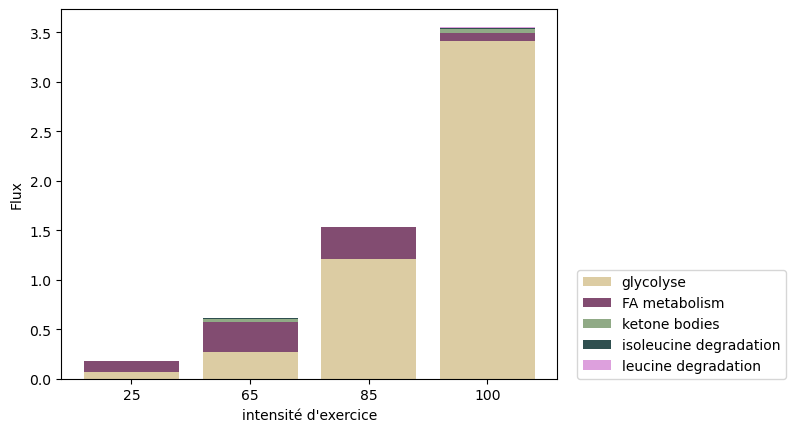

{'25': {'glycolyse': 0.06999999999999999,
  'beta oxydation': 0.10632476445789181,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.004},
 '65': {'glycolyse': 0.26999999999999996,
  'beta oxydation': 0.2999999999999999,
  'ketone bodies': 0.03544444444444613,
  'leucine degradation': 9.891493532802258e-18,
  'isoleucine degradation': 0.0039999999999997884},
 '85': {'glycolyse': 1.2099999999999937,
  'beta oxydation': 0.32,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.004},
 '100': {'glycolyse': 3.4100000000000046,
  'beta oxydation': 0.08,
  'ketone bodies': 0.048,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.004}}

In [57]:
dict_results_voie_metabolique["25"]=output25[1]
dict_results_voie_metabolique["65"]=output65[1]
dict_results_voie_metabolique["85"]=output85[1]
dict_results_voie_metabolique["100"]=output100[1]
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_voie_metabolique,"plot_mouse_voie_metabolique.png")

In [58]:
dict_results_voie_metabolique_proportion = build_dict_proportion(dict_pathway=dict_results_voie_metabolique, dict_tot={'25':0,'65':0,'85':0, '100':0}, dict_prop={'25':{},'65':{},'85':{}, '100':{}})

{'glycolyse': 0.38818850095515256, 'beta oxydation': 0.5896292989902673, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.02218220005458015}
{'glycolyse': 0.44302643573381845, 'beta oxydation': 0.49225159525979817, 'ketone bodies': 0.05815861440291969, 'leucine degradation': 1.6230344903412968e-17, 'isoleucine degradation': 0.006563354603463631}
{'glycolyse': 0.788787483702737, 'beta oxydation': 0.20860495436766707, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.0026075619295958387}
{'glycolyse': 0.9584035975267005, 'beta oxydation': 0.022484541877459217, 'ketone bodies': 0.01349072512647553, 'leucine degradation': 0.004496908375491843, 'isoleucine degradation': 0.0011242270938729608}
['25' '65' '85' '100']


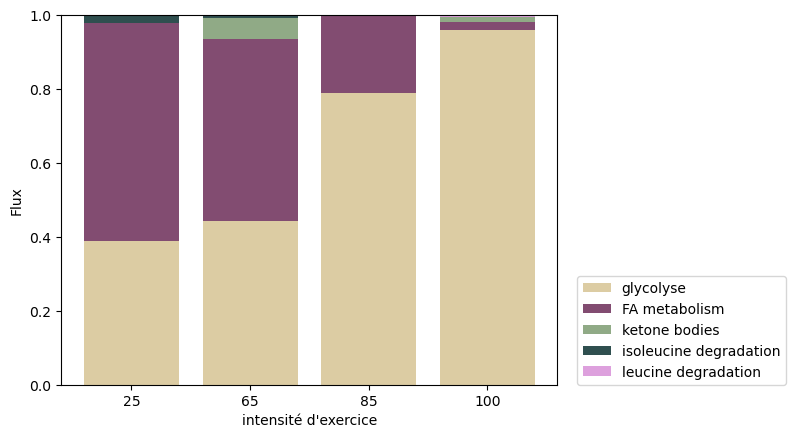

{'25': {'glycolyse': 0.38818850095515256,
  'beta oxydation': 0.5896292989902673,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.02218220005458015},
 '65': {'glycolyse': 0.44302643573381845,
  'beta oxydation': 0.49225159525979817,
  'ketone bodies': 0.05815861440291969,
  'leucine degradation': 1.6230344903412968e-17,
  'isoleucine degradation': 0.006563354603463631},
 '85': {'glycolyse': 0.788787483702737,
  'beta oxydation': 0.20860495436766707,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.0026075619295958387},
 '100': {'glycolyse': 0.9584035975267005,
  'beta oxydation': 0.022484541877459217,
  'ketone bodies': 0.01349072512647553,
  'leucine degradation': 0.004496908375491843,
  'isoleucine degradation': 0.0011242270938729608}}

In [59]:
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_voie_metabolique_proportion,"plot_mouse_voie_metabolique_proportion.png")

{'FA and ketone body metabolism / Ketogenesis': 29.25, 'FA metabolism': 70.74, 'Isoleucine degradation': 0, 'TCA cycle': 0, 'Ketogenesis / Leucine degradation': 0}
{'Isoleucine degradation': 0.15, 'FA and ketone body metabolism / Ketogenesis': 29.92, 'FA metabolism': 69.11999999999999, 'TCA cycle': 0.81, 'Ketogenesis / Leucine degradation': 0}
{'Isoleucine degradation': 0.1, 'FA and ketone body metabolism / Ketogenesis': 26.54, 'FA metabolism': 49.739999999999995, 'TCA cycle': 23.6, 'Ketogenesis / Leucine degradation': 0}
{'Isoleucine degradation': 0.08, 'FA and ketone body metabolism / Ketogenesis': 12.56, 'Ketogenesis / Leucine degradation': 0.34, 'FA metabolism': 10.139999999999999, 'TCA cycle': 76.9}
['25' '65' '85' '100']


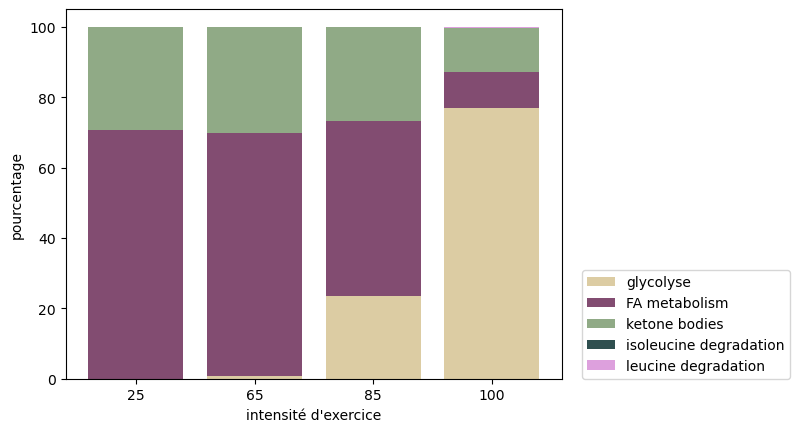

{'25': {'FA and ketone body metabolism / Ketogenesis': 29.25,
  'FA metabolism': 70.74,
  'Isoleucine degradation': 0,
  'TCA cycle': 0,
  'Ketogenesis / Leucine degradation': 0},
 '65': {'Isoleucine degradation': 0.15,
  'FA and ketone body metabolism / Ketogenesis': 29.92,
  'FA metabolism': 69.11999999999999,
  'TCA cycle': 0.81,
  'Ketogenesis / Leucine degradation': 0},
 '85': {'Isoleucine degradation': 0.1,
  'FA and ketone body metabolism / Ketogenesis': 26.54,
  'FA metabolism': 49.739999999999995,
  'TCA cycle': 23.6,
  'Ketogenesis / Leucine degradation': 0},
 '100': {'Isoleucine degradation': 0.08,
  'FA and ketone body metabolism / Ketogenesis': 12.56,
  'Ketogenesis / Leucine degradation': 0.34,
  'FA metabolism': 10.139999999999999,
  'TCA cycle': 76.9}}

In [60]:
dict_results_accoa["25"]=output25[0]
dict_results_accoa["65"]=output65[0]
dict_results_accoa["85"]=output85[0]
dict_results_accoa["100"]=output100[0]

Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_accoa,"plot_mouse_accoa.png",accoa=True)

In [61]:
# dict_results_atp["25"]=output25[4]
# dict_results_atp["65"]=output65[4]
# dict_results_atp["85"]=output85[4]
# Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_atp,"plot_mouse_atp.png")


In [62]:
mitocore_mouse25.metabolites.accoa_c.summary()


Percent,Flux,Reaction,Definition
Percent,Flux,Reaction,Definition


## Mice model Calpainopathy

In [63]:
############################ calpainopathy

# solution_25_calpainopathy=Utils_Cobrapy.run_model_calpainopathy(modification_file="model_convertion.csv",
#     model=mitocore_mouse25,O2_upper_bound=3.7,glucose_upper_bound=0.03,
#     FA_upper_bound=0.1,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114)


# solution_65_calpainopathy=Utils_Cobrapy.run_model_calpainopathy(modification_file="model_convertion.csv",
#     model=mitocore_mouse65,O2_upper_bound=7.9,glucose_upper_bound=0.13,
#     FA_upper_bound=0.23,hydroxybutyrate_upper_bound=0.048,
#     Acetoacetate_upper_bound=0.114)

# solution_85_calpainopathy=Utils_Cobrapy.run_model_calpainopathy(modification_file="model_convertion.csv",
#     model=mitocore_mouse85,O2_upper_bound=11.1,glucose_upper_bound=0.6,
#     FA_upper_bound=0.25,hydroxybutyrate_upper_bound=0.048,
#     Acetoacetate_upper_bound=0.114)

solution_100_calpainopathy=Utils_Cobrapy.run_model_calpainopathy(modification_file="model_convertion.csv",
    model=mitocore_mouse100_calpain,O2_upper_bound=14,glucose_upper_bound=1.7,
    FA_upper_bound=0.8,hydroxybutyrate_upper_bound=0.048,
    Acetoacetate_upper_bound=0.114)

accoa_m
Formula: C23H34N7O17P3S

Producing Reactions
-------------------
Percent    Flux        Reaction                                                                  Definition
  0.08%   0.002        ACACT10m                                     2maacoa_m + coa_m --> accoa_m + ppcoa_m
  5.82%   0.138        ACACT1rm                                             2.0 accoa_m <=> aacoa_m + coa_m
  1.31% 0.03099 MTPC14_MitoCore 3tetd7ecoa_m + coa_m + h2o_m + nad_m <=> accoa_m + ddcacoa_m + h_m + nadh_m
  1.31% 0.03099 MTPC16_MitoCore 3hexdcoa_m + coa_m + h2o_m + nad_m <=> accoa_m + h_m + nadh_m + tetd7ecoa_m
 86.25%   2.044            PDHm                          coa_m + nad_m + pyr_m --> accoa_m + co2_m + nadh_m
  1.31% 0.03099           r0287                                     HC01408_m + coa_m <=> accoa_m + btcoa_m
  1.31% 0.03099           r0634                                      accoa_m + occoa_m <=> 3odcoa_m + coa_m
  1.31% 0.03099           r0724                                

In [64]:
upperbounds_calpainopathy = solution_100_calpainopathy[3].to_frame()

In [65]:
model_bis = solution_100_calpainopathy[2]

In [66]:
# Takes the same bounds as the 100% condition
models_calpain = [mitocore_mouse25_calpain, mitocore_mouse65_calpain, mitocore_mouse85_calpain]

for model in models_calpain:
    print(f"----------{model}----------")
    for id_reaction, row in upperbounds_calpainopathy.iterrows():
        if model_bis.reactions.get_by_id(id_reaction).upper_bound != model.reactions.get_by_id(id_reaction).upper_bound:
            print(id_reaction)
            print(model_bis.reactions.get_by_id(id_reaction).upper_bound)
            print(model.reactions.get_by_id(id_reaction).upper_bound)
            try :
                model.reactions.get_by_id(id_reaction).upper_bound = model_bis.reactions.get_by_id(id_reaction).upper_bound
            except ValueError:
                print(f"{id_reaction} : impossible")
                pass


----------S1SBMLmodel----------
FBA
0.8500000000000001
1000.0
CSm
2.3697173913043477
1000.0
AKGDm
19.713244610676938
1000.0
CV_MitoCore
33.72922924595969
1000.0
ICDHy
0
1000.0
r0722
0.04190217391304339
1000.0
r0726
0.04190217391304339
1000.0
r0730
0.04190217391304339
1000.0
r0733
0.04190217391304339
1000.0
HACD1m
0
1000.0
BDHm
0.024
1000.0
HACD9m
0.002
1000.0
SPODMm
0.011269198193111238
1000.0
O2t
14
19.8
GLCt1r
1.7
0.9
HDCAtr
0.8
1.0
L_LACt2r
0
0.575
----------S1SBMLmodel----------
FBA
0.8500000000000001
1000.0
CSm
2.3697173913043477
1000.0
AKGDm
19.713244610676938
1000.0
CV_MitoCore
33.72922924595969
1000.0
ICDHy
0
1000.0
r0722
0.04190217391304339
1000.0
r0726
0.04190217391304339
1000.0
r0730
0.04190217391304339
1000.0
r0733
0.04190217391304339
1000.0
HACD1m
0
1000.0
BDHm
0.024
1000.0
HACD9m
0.002
1000.0
SPODMm
0.011269198193111238
1000.0
O2t
14
19.8
GLCt1r
1.7
0.9
HDCAtr
0.8
1.0
L_LACt2r
0
0.575
----------S1SBMLmodel----------
FBA
0.8500000000000001
1000.0
CSm
2.3697173913043477
100

In [67]:
# # Takes fluxes from solution of condition 100% as bounds
# for id_reaction, row in upperbounds_calpainopathy.iterrows():
#     try :
#         mitocore_mouse_calpain.reactions.get_by_id(id_reaction).upper_bound = row['fluxes']
#     except ValueError:
#         print(f"{id_reaction} : impossible")
#         pass

In [68]:
O2_ub_25 = min(mitocore_mouse25_calpain.reactions.O2t.upper_bound, 3.7)
GLC_ub_25 = min(mitocore_mouse25_calpain.reactions.GLCt1r.upper_bound, 0.03)
FA_ub_25 = min(mitocore_mouse25_calpain.reactions.HDCAtr.upper_bound, 0.12)
ATP_ub_25 = min(mitocore_mouse25_calpain.reactions.OF_ATP_MitoCore.upper_bound, 14.6)

O2_ub_65 = min(mitocore_mouse65_calpain.reactions.O2t.upper_bound, 7.9)
GLC_ub_65 = min(mitocore_mouse65_calpain.reactions.GLCt1r.upper_bound, 0.13)
FA_ub_65 = min(mitocore_mouse65_calpain.reactions.HDCAtr.upper_bound, 0.3)
ATP_ub_65 = min(mitocore_mouse65_calpain.reactions.OF_ATP_MitoCore.upper_bound, 36.52)

O2_ub_85 = min(mitocore_mouse85_calpain.reactions.O2t.upper_bound, 11.1)
GLC_ub_85 = min(mitocore_mouse85_calpain.reactions.GLCt1r.upper_bound, 0.6)
FA_ub_85 = min(mitocore_mouse85_calpain.reactions.HDCAtr.upper_bound, 0.32)
ATP_ub_85 = min(mitocore_mouse85_calpain.reactions.OF_ATP_MitoCore.upper_bound, 54.8)

In [69]:
O2_ub_25

3.7

In [70]:
if VO2max_25:
    output25_calpain=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse25_calpain,O2_upper_bound=O2_ub_25,glucose_upper_bound=GLC_ub_25,
        FA_upper_bound=FA_ub_25,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=ATP_ub_25)

if VO2max_65:
    # mitocore_mouse.reactions.r0732.bounds = (0.75,1000)
    output65_calpain=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse65_calpain,O2_upper_bound=O2_ub_65,glucose_upper_bound=GLC_ub_65,
        FA_upper_bound=FA_ub_65,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=ATP_ub_65)

if VO2max_85:
    # mitocore_mouse.reactions.r0732.bounds = (1,1000)
    output85_calpain=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse85_calpain,O2_upper_bound=O2_ub_85,glucose_upper_bound=GLC_ub_85,
        FA_upper_bound=FA_ub_85,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=ATP_ub_85)

accoa_m
Formula: C23H34N7O17P3S

Producing Reactions
-------------------
Percent   Flux        Reaction                                                                  Definition
  0.19%  0.002        ACACT10m                                     2maacoa_m + coa_m --> accoa_m + ppcoa_m
 48.15% 0.5018        ACACT1rm                                             2.0 accoa_m <=> aacoa_m + coa_m
  1.54%  0.016           HMGLm                                               hmgcoa_m --> acac_m + accoa_m
  4.02% 0.0419 MTPC14_MitoCore 3tetd7ecoa_m + coa_m + h2o_m + nad_m <=> accoa_m + ddcacoa_m + h_m + nadh_m
  4.02% 0.0419 MTPC16_MitoCore 3hexdcoa_m + coa_m + h2o_m + nad_m <=> accoa_m + h_m + nadh_m + tetd7ecoa_m
 26.00%  0.271            PDHm                          coa_m + nad_m + pyr_m --> accoa_m + co2_m + nadh_m
  4.02% 0.0419           r0287                                     HC01408_m + coa_m <=> accoa_m + btcoa_m
  4.02% 0.0419           r0634                                      acc

In [71]:
dict_results_calpain_voie_metabolique=dict()
dict_results_calpain_accoa=dict()

### Building dataframes

#### Dataframes for treemaps

In [72]:
solution25_calpain = output25_calpain[3]
solution65_calpain = output65_calpain[3]
solution85_calpain = output85_calpain[3]

In [73]:
dt25_calpain = build_dataframe(mitocore_mouse25_calpain, solution25_calpain, 0, 18)
dt65_calpain = build_dataframe(mitocore_mouse65_calpain, solution65_calpain, 0, 18)
dt85_calpain = build_dataframe(mitocore_mouse85_calpain, solution85_calpain, 0, 18)

#### Dataframes of all fluxes

In [74]:
all_fluxes_25_calpain = build_dataframe_visual(mitocore_mouse25_calpain, solution25_calpain)

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |              -0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

In [75]:
all_fluxes_65_calpain = build_dataframe_visual(mitocore_mouse65_calpain, solution65_calpain)

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |     0           | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |     0           | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |    -0.443243    | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |    -0           | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |    -4.44089e-

In [76]:
all_fluxes_85_calpain = build_dataframe_visual(mitocore_mouse85_calpain, solution85_calpain)

|                          |      fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0         |    -1.77636e-15 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0         |     0           | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0         |    -0.443243    | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0         |    -0           | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0         |     0           | Alcohol m

### Flux Variability Analysis

In [77]:
fva25_calpain = output25_calpain[5]
fva65_calpain = output65_calpain[5]
fva85_calpain = output85_calpain[5]

In [78]:
alternative25_calpain = get_alternative_pathways(fva25_calpain)
alternative65_calpain = get_alternative_pathways(fva65_calpain)
alternative85_calpain = get_alternative_pathways(fva85_calpain)

In [79]:
reaction_to_check_25_calpain = get_reactions_to_check(all_fluxes_25_calpain, alternative25_calpain, 'FA metabolism')
reaction_to_check_65_calpain = get_reactions_to_check(all_fluxes_65_calpain, alternative65_calpain, 'FA metabolism')
reaction_to_check_85_calpain = get_reactions_to_check(all_fluxes_85_calpain, alternative85_calpain, 'FA metabolism')

In [80]:
reaction_to_check_25

['PPAm']

In [81]:
print_alternative_reactions(reaction_to_check_25, fva25_calpain)

minimum    0.00000
maximum    1.10794
Name: PPAm, dtype: float64
---------------------------


### Building treemaps

In [82]:
display_treemap(dt25_calpain, 'calpain 25')
display_treemap(dt65_calpain, 'calpain 65')
display_treemap(dt85_calpain, 'calpain 85')

### Relative contributions of pathways during exercise

In [83]:
# dict_results_calpain_voie_metabolique["25"]=solution_25_calpainopathy[1]
# dict_results_calpain_voie_metabolique["65"]=solution_65_calpainopathy[1]
# dict_results_calpain_voie_metabolique["85"]=solution_85_calpainopathy[1]
# Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_calpain_voie_metabolique,"plot_mouse_calpain_voie_metabolique.png")

{'glycolyse': 0.06999999999999999, 'beta oxydation': 0.04190217391304339, 'ketone bodies': 0.024, 'leucine degradation': 0.016, 'isoleucine degradation': 0.0019999999999999983}
{'glycolyse': 0.27, 'beta oxydation': 0.04190217391304339, 'ketone bodies': 0.024, 'leucine degradation': 0.016, 'isoleucine degradation': 0.002}
{'glycolyse': 1.2099999999999986, 'beta oxydation': 0.04190217391304339, 'ketone bodies': 0.024, 'leucine degradation': 0.016, 'isoleucine degradation': 0.002}
['25' '65' '85']


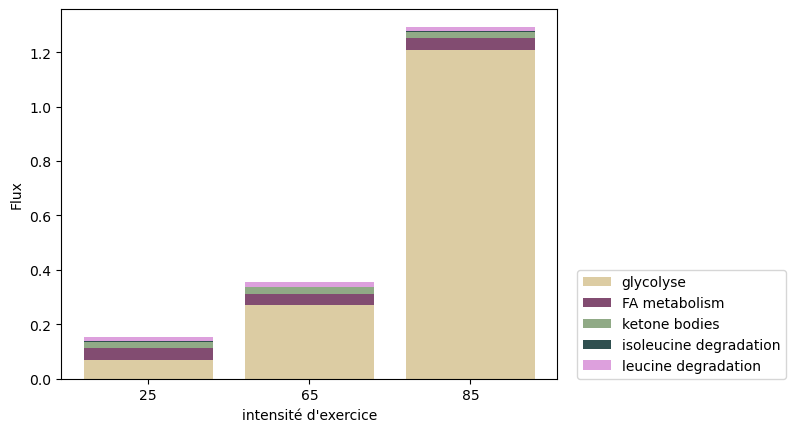

{'25': {'glycolyse': 0.06999999999999999,
  'beta oxydation': 0.04190217391304339,
  'ketone bodies': 0.024,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.0019999999999999983},
 '65': {'glycolyse': 0.27,
  'beta oxydation': 0.04190217391304339,
  'ketone bodies': 0.024,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.002},
 '85': {'glycolyse': 1.2099999999999986,
  'beta oxydation': 0.04190217391304339,
  'ketone bodies': 0.024,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.002}}

In [84]:
dict_results_calpain_voie_metabolique["25"]=output25_calpain[1]
dict_results_calpain_voie_metabolique["65"]=output65_calpain[1]
dict_results_calpain_voie_metabolique["85"]=output85_calpain[1]
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_calpain_voie_metabolique,"plot_mouse_calpain_voie_metabolique.png")

In [85]:
dict_results_voie_metabolique_proportion_calpain = build_dict_proportion(dict_pathway=dict_results_calpain_voie_metabolique)

{'glycolyse': 0.4548343809591075, 'beta oxydation': 0.27226499046542796, 'ketone bodies': 0.15594321632883687, 'leucine degradation': 0.10396214421922458, 'isoleucine degradation': 0.012995268027403062}
{'glycolyse': 0.7629226941859395, 'beta oxydation': 0.11840044227402538, 'ketone bodies': 0.06781535059430573, 'leucine degradation': 0.04521023372953715, 'isoleucine degradation': 0.0056512792161921436}
{'glycolyse': 0.9351557052730617, 'beta oxydation': 0.03238434462655093, 'ketone bodies': 0.01854854291450703, 'leucine degradation': 0.012365695276338021, 'isoleucine degradation': 0.0015457119095422527}
['25' '65' '85']


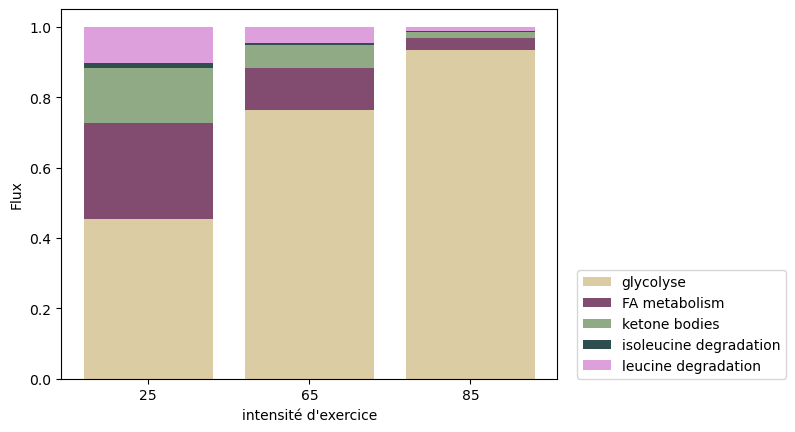

{'25': {'glycolyse': 0.4548343809591075,
  'beta oxydation': 0.27226499046542796,
  'ketone bodies': 0.15594321632883687,
  'leucine degradation': 0.10396214421922458,
  'isoleucine degradation': 0.012995268027403062},
 '65': {'glycolyse': 0.7629226941859395,
  'beta oxydation': 0.11840044227402538,
  'ketone bodies': 0.06781535059430573,
  'leucine degradation': 0.04521023372953715,
  'isoleucine degradation': 0.0056512792161921436},
 '85': {'glycolyse': 0.9351557052730617,
  'beta oxydation': 0.03238434462655093,
  'ketone bodies': 0.01854854291450703,
  'leucine degradation': 0.012365695276338021,
  'isoleucine degradation': 0.0015457119095422527}}

In [86]:
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_voie_metabolique_proportion_calpain,"plot_mouse_voie_metabolique_proportion_calpain.png")

####  Pourquoi les ketones bodies apparaissent dans dans la production d'acetyl coa mais pas dans la voie métabolique des ketone bodies :
La voie "ketone bodies" de production d'acetyl coa est en fait la voie "FA and ketone body metabolism / Ketogenesis" et inclut donc la le métabolisme lipidique

cela n'explique pour autant pas tout car la voie métabolique des lipides n'est pas détéctée.

In [87]:
# dict_results_calpain_accoa["25"]=solution_25_calpainopathy[0]
# dict_results_calpain_accoa["65"]=solution_65_calpainopathy[0]
# dict_results_calpain_accoa["85"]=solution_85_calpainopathy[0]
# print(dict_results_calpain_accoa)
# Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_calpain_accoa,"plot_mouse_calpain_accoa.png",accoa=True)

In [88]:
######## A FAIRE : COMPARAISON FLUX PAR FLUX

In [89]:
#comparaison des flux entre calpainopathy
# Utils_Cobrapy.heatmap_flux(save=True,solutions=[solution_25_calpainopathy[3],solution_65_calpainopathy[3],solution_85_calpainopathy[3]]
#                           ,name_columns=["25calpain","65calpain","85calpain"],name_plot="Plots/heatmap_flux_calpain.png")


In [90]:
#comparaison des flux entre conditions saines
# Utils_Cobrapy.heatmap_flux(save=True,solutions=[output25[3],output65[3],output85[3]]
#                           ,name_columns=["25","65","85"],name_plot="Plots/heatmap_flux_sain.png")

In [91]:
#comparaison des flux entre conditions saines et malades
# Utils_Cobrapy.heatmap_flux(save=True,name_plot="Plots/heatmap_compare_flux_sain_calpain.png",
#     solutions=[output25[3],solution_25_calpainopathy[3]
#                                       ,output65[3],solution_65_calpainopathy[3]
#                                       ,output85[3],solution_85_calpainopathy[3]]
#                           ,name_columns=["25","calpain25","65","calpain65","85","calpain85"])

## Visualisation

### Essaie map escher

In [92]:
# builder25 = Builder(map_json="./Models/RECON1.Glycolysis TCA PPP.json", model=mitocore_mouse25, reaction_data=solution25.fluxes)
# builder25.height = 800
# builder25

In [93]:
# builder65 = Builder(map_json="./Models/RECON1.Glycolysis TCA PPP.json", model=mitocore_mouse65, reaction_data=solution65.fluxes)
# builder65.height = 800
# builder65

In [94]:
# builder85 = Builder(map_json="./Models/RECON1.Glycolysis TCA PPP.json", model=mitocore_mouse85, reaction_data=solution85.fluxes)
# builder85.height = 800
# builder85

In [95]:
# builder100 = Builder(map_json="./Models/RECON1.Glycolysis TCA PPP.json", model=mitocore_mouse100, reaction_data=solution100.fluxes)
# builder100.height = 800
# builder100

### Reactions/Metabolites

In [96]:
print(mitocore_mouse25.reactions.OF_ATP_MitoCore)


OF_ATP_MitoCore: atp_c + h2o_c --> adp_c + biomass_c + h_c + pi_c


In [97]:
print_reactions_from_met(mitocore_mouse85, 'q10_m', solution85, False)

CIII_MitoCore: 2.0 PMF_m + 2.0 ficytC_m + q10h2_m <=> 4.0 PMF_c + 2.0 focytC_m + q10_m
fluxes           22.171282
reduced_costs     0.000000
Name: CIII_MitoCore, dtype: float64
--------
CII_MitoCore: q10_m + succ_m <=> fum_m + q10h2_m
fluxes           3.8115
reduced_costs    0.0000
Name: CII_MitoCore, dtype: float64
--------
r0541: glutcoa_m + h_m + q10_m --> b2coa_m + co2_m + q10h2_m
fluxes           0.03
reduced_costs    0.00
Name: r0541, dtype: float64
--------
r1446: btcoa_m + q10_m --> b2coa_m + q10h2_m
fluxes           0.32
reduced_costs    0.00
Name: r1446, dtype: float64
--------
ACADLC16_MitoCore: h2o_m + pmtcoa_m + q10_m --> 3hexdcoa_m + q10h2_m
fluxes           1.133851
reduced_costs    0.000000
Name: ACADLC16_MitoCore, dtype: float64
--------
CI_MitoCore: 3.996 PMF_m + h_m + nadh_m + 0.002 o2_m + 0.999 q10_m <=> 3.996 PMF_c + nad_m + 0.002 o2s_m + 0.999 q10h2_m
fluxes           14.35879
reduced_costs     0.00000
Name: CI_MitoCore, dtype: float64
--------
r0655: ivcoa_m + q1

In [98]:
get_reactions_from_subsys(mitocore_mouse85, all_fluxes_85, ["TCA cycle", "TCA cycle periphery", "Electron transport chain CI", "Electron transport chain CII", 
                                                          "Electron transport chain CIII", "Electron transport chain CIV", "Electron transport chain CV" ])


------ Reactions from TCA cycle -------

SUCOASm: atp_m + coa_m + succ_m <=> adp_m + pi_m + succoa_m
-3.8115000000000006

SUCOAS1m: coa_m + gtp_m + succ_m <=> gdp_m + pi_m + succoa_m
0.0

ICDHyrm: icit_m + nadp_m <=> akg_m + co2_m + nadph_m
0.5522098393574386

PDHm: coa_m + nad_m + pyr_m --> accoa_m + co2_m + nadh_m
1.1515000000000009

ICDHxm: icit_m + nad_m --> akg_m + co2_m + nadh_m
3.223290160642562

CSm: accoa_m + h2o_m + oaa_m --> cit_m + coa_m + h_m
3.7755000000000005

ACONTm: cit_m <=> icit_m
3.7755000000000005

MDHm: mal_L_m + nad_m <=> h_m + nadh_m + oaa_m
3.7755000000000005

AKGDm: akg_m + coa_m + nad_m --> co2_m + nadh_m + succoa_m
3.7965000000000004

FUMm: fum_m + h2o_m <=> mal_L_m
3.8115000000000006


------ Reactions from TCA cycle periphery -------

PEPCKm: gtp_m + oaa_m --> co2_m + gdp_m + pep_m
0.0

PCm: atp_m + hco3_m + pyr_m --> adp_m + h_m + oaa_m + pi_m
0.0

ME1m: mal_L_m + nad_m --> co2_m + nadh_m + pyr_m
0.0

r0081: akg_m + ala_L_m <=> glu_L_m + pyr_m
0.0

ACITL

In [99]:
print(mitocore_mouse100.groups.get_by_any("Leucine degradation")[0])

Leucine degradation
